In [1]:
from __future__ import print_function, division

import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

cudnn.benchmark = True
plt.ion()   # interactive mode
# Creates a runs/baseline_resnet18_dataaugmented folder
writer = SummaryWriter("TensorBoard/runs/resnet18")

# 1. Organize and load data

In [4]:
# Split with a ratioof  80% to training set and 10% for validation and test set
splitfolders.ratio("images", output="data", seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 4000 files [00:03, 1026.96 files/s]


In [2]:
# Data normalization and re-scaling for each of the sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((240,240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((240,240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((240,240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
data_dir = 'data/'

# Get data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

# Load data into gpu
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1.1 Visualize some examples

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

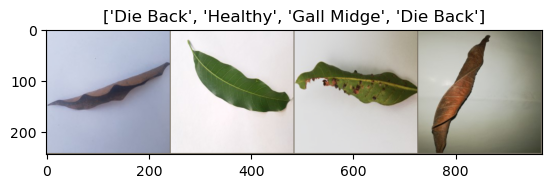

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 2. Create model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            batch_index = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                # Move the data to the proper device (GPU or CPU)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                
                # Write the loss and accuracy to TensorBoard
                writer.add_scalar('Loss/' + phase, batch_loss, epoch * len(dataloaders[phase]) + batch_index)
                writer.add_scalar('Accuracy/' + phase, batch_corrects / inputs.size(0), epoch * len(dataloaders[phase]) + batch_index)
                
                batch_index += 1
            # lr_scheduler provides several methods to adjust the learning rate based on the number of epochs
            if phase == 'train':
                scheduler.step()
                
            # Loss and accuracy of the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.flush()
    return model

## 2.1 Visualize model predictions

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\n real-class: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 2.2 Finetune the ResNet Model

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

num_classes = 8
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes) 

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 3. Train and evaluate model

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 800/800 [00:18<00:00, 43.41it/s]


train Loss: 0.4160 Acc: 0.8634


100%|██████████| 100/100 [00:02<00:00, 34.15it/s]


val Loss: 0.0625 Acc: 0.9900

Epoch 1/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.01it/s]


train Loss: 0.1698 Acc: 0.9469


100%|██████████| 100/100 [00:02<00:00, 34.30it/s]


val Loss: 0.0159 Acc: 0.9950

Epoch 2/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.90it/s]


train Loss: 0.1210 Acc: 0.9650


100%|██████████| 100/100 [00:02<00:00, 33.58it/s]


val Loss: 0.0150 Acc: 0.9950

Epoch 3/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.96it/s]


train Loss: 0.0953 Acc: 0.9753


100%|██████████| 100/100 [00:02<00:00, 34.32it/s]


val Loss: 0.0176 Acc: 0.9950

Epoch 4/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.82it/s]


train Loss: 0.0626 Acc: 0.9834


100%|██████████| 100/100 [00:02<00:00, 34.11it/s]


val Loss: 0.0085 Acc: 0.9975

Epoch 5/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.56it/s]


train Loss: 0.0625 Acc: 0.9834


100%|██████████| 100/100 [00:02<00:00, 33.68it/s]


val Loss: 0.0226 Acc: 0.9950

Epoch 6/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.25it/s]


train Loss: 0.0376 Acc: 0.9894


100%|██████████| 100/100 [00:02<00:00, 34.12it/s]


val Loss: 0.0022 Acc: 1.0000

Epoch 7/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.21it/s]


train Loss: 0.0257 Acc: 0.9931


100%|██████████| 100/100 [00:02<00:00, 33.96it/s]


val Loss: 0.0010 Acc: 1.0000

Epoch 8/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.91it/s]


train Loss: 0.0204 Acc: 0.9950


100%|██████████| 100/100 [00:02<00:00, 33.57it/s]


val Loss: 0.0021 Acc: 1.0000

Epoch 9/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.62it/s]


train Loss: 0.0169 Acc: 0.9956


100%|██████████| 100/100 [00:02<00:00, 33.89it/s]

val Loss: 0.0004 Acc: 1.0000

Training complete in 3m 16s
Best val Acc: 1.000000


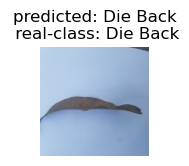

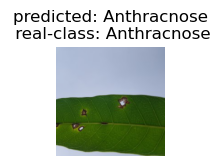

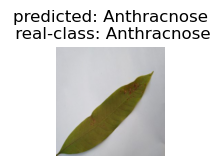

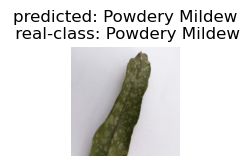

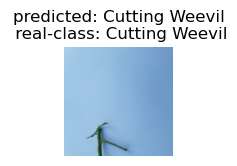

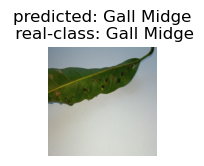

In [17]:
visualize_model(model_ft)

# 4. Loss and accuracy plots

In [70]:
from IPython.display import SVG, display

def plot_svg_images(filename):
    print(filename[20:-4])
    display(SVG(filename=filename))

Accuracy_train


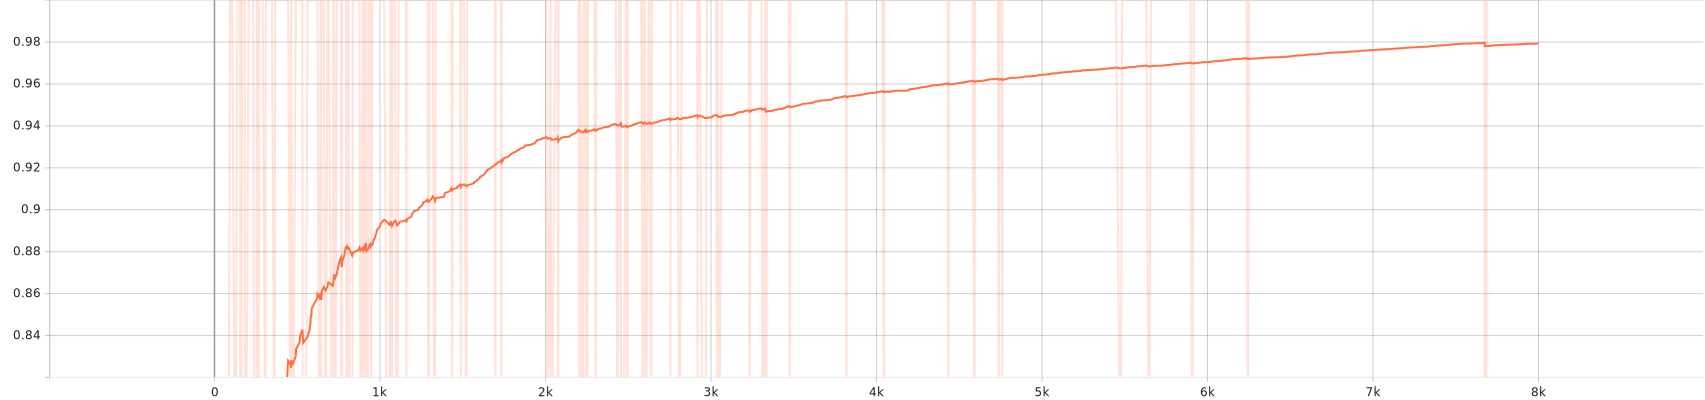

Accuracy_val


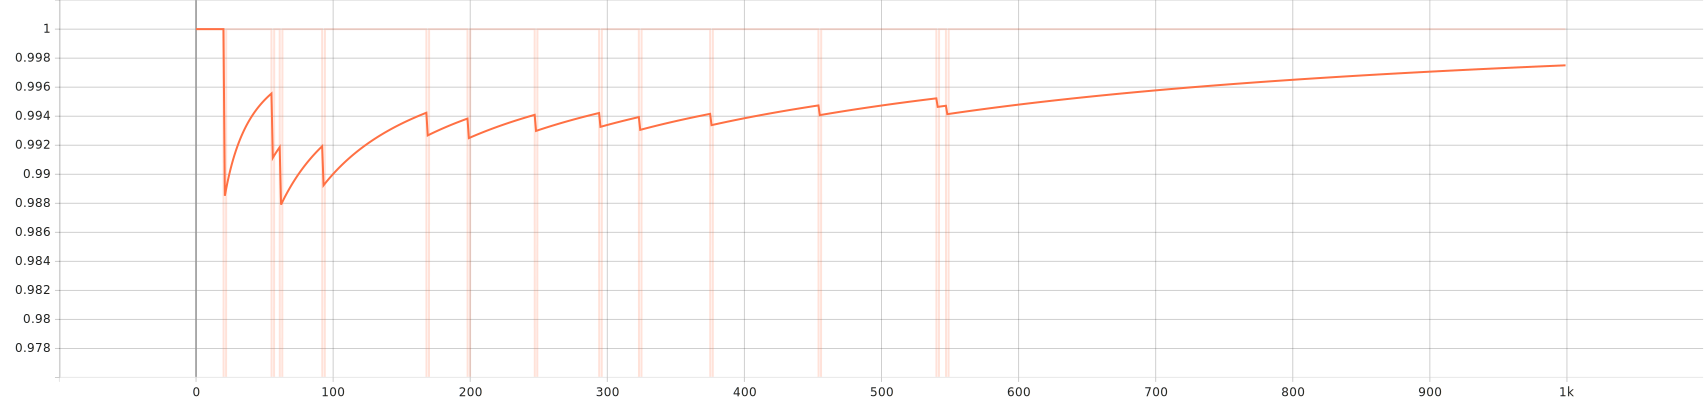

Loss_train


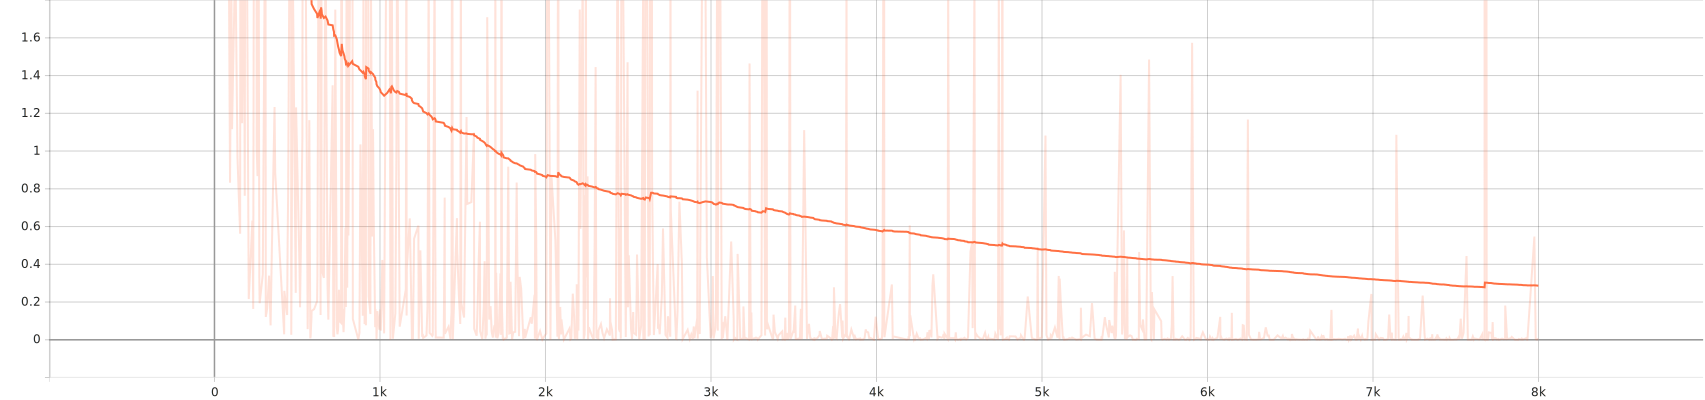

Loss_val


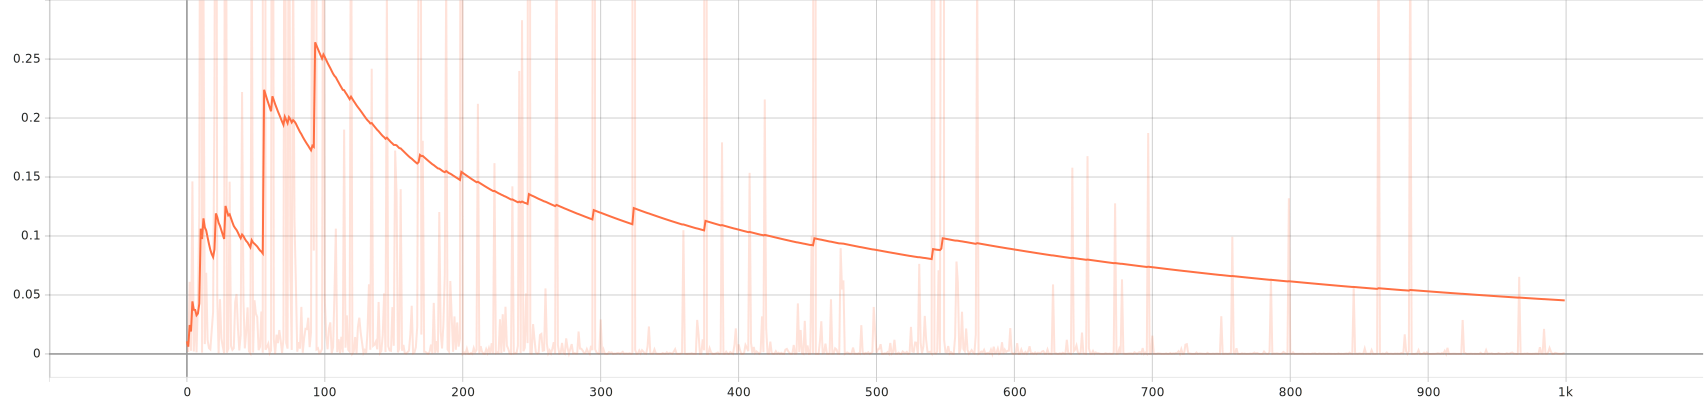

In [71]:
import os
graphs = os.listdir('loss-accuracy-plots')
graphs = ['loss-accuracy-plots/'+graph for graph in graphs]

for graph in graphs:
    plot_svg_images(graph)

# 5. Accuracy in test set

In [24]:
# Make a matrix whose row represents true labels and column represents prediction labels
def create_prediction_matrix(model, dataset, num_images, batch_size):
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) 
                   for x in ['train', 'val', 'test']}
    
    was_training = model.training
    model.eval()
    images_so_far = 0

    prediction_matrix = np.zeros((num_classes, num_classes)).astype(int)

    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[dataset])):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Iterate through predictions for one batch
            for j in range(inputs.size()[0]):
                prediction_matrix[labels[j]][preds[j]] += 1        
                images_so_far += 1

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return prediction_matrix
        model.train(mode=was_training)
        return prediction_matrix
    


def normalize_prediciton_matrix(prediction_matrix):
    normalized_prediction_matrix = np.zeros((num_classes, num_classes))
    for j in range(num_classes):
        column_sum = np.sum(prediction_matrix[:, j])
        if column_sum != 0:
            normalized_prediction_matrix[:, j] = prediction_matrix[:, j] / column_sum
    return np.around(normalized_prediction_matrix, decimals=1)

In [48]:
def visualize_matrix(matrix, img_name):
    plt.figure(figsize = (100, 100))
    plt.rcParams['figure.figsize'] = (50, 50)
    plt.matshow(matrix)
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    plt.title("Prediction Results", fontsize=24)
    plt.xticks(ticks=np.arange(0, 8), labels=class_names, rotation="vertical", fontsize=15)
    plt.yticks(ticks=np.arange(0, 8), labels=class_names, fontsize=15)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("bottom")
    
    for i in range(num_classes):
        for j in range(num_classes):
            if matrix[i, j] != 0:
                text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black", fontsize=20)
    
    plt.savefig(img_name) 
    plt.show()

In [23]:
prediction_matrix = create_prediction_matrix(model_ft, 'test', 400, 4)

99it [00:02, 40.14it/s] 


<Figure size 10000x10000 with 0 Axes>

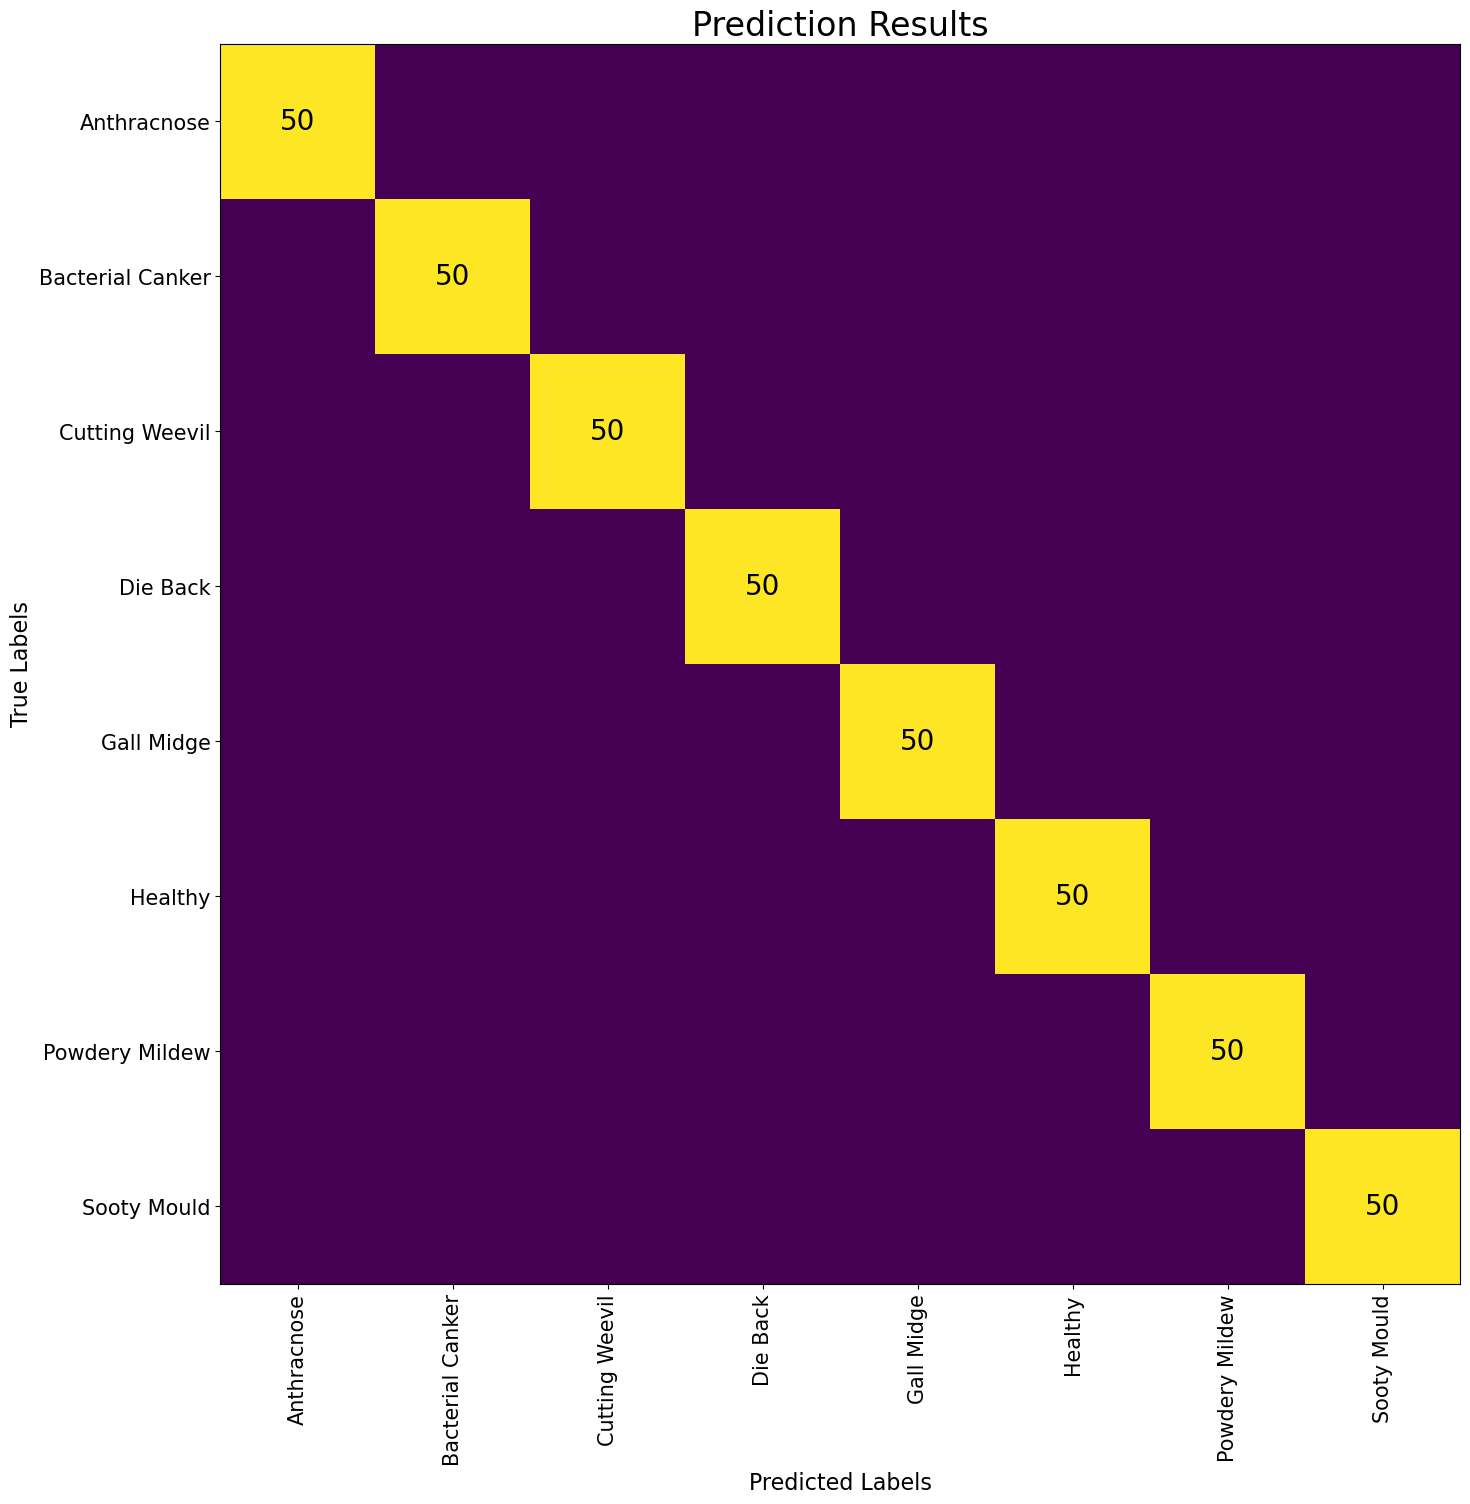

In [49]:
visualize_matrix(prediction_matrix, 'confusion_matrix.png')